In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

data = pd.read_csv('data/creditcard/creditcard.csv').drop_duplicates()

In [2]:
# Original dataset
X_frauds = data[data['Class'] == 1].drop(['Class', 'Time'], axis=1)
y_frauds = data[data['Class'] == 1].Class
X_genuine = data[data['Class'] == 0].drop(['Class', 'Time'], axis=1)
y_genuine = data[data['Class'] == 0].Class

# Downsampling
n = len(y_frauds)
X_down, y_down = resample(X_genuine, y_genuine, n_samples=n, random_state=404)

# Combining frauds and reduced genuine datasets into one
X = pd.concat([X_frauds, X_down], axis=0)
y = pd.concat([y_frauds, y_down], axis=0)

In [3]:
X_train, X_test, y_train, y_true = train_test_split(
    X, y,
    test_size=.2,
    random_state=404
)

In [5]:
X_test_large, y_true_large = resample(data.drop(['Class', 'Time'], axis=1), data.Class, stratify=data.Class, n_samples=int(.2*len(data)), random_state=404)

In [6]:
# For reduced data size:

selected_columns = [
    'V17',
    'V14',
    'V12',
    'V10',
    'V16',
    'V3',
    'V7',
    'V11',
    'V4',
    'V18',
    'V1',
    'V9',
    'V5',
    'V2',
]
X_train_reduced, X_test_reduced, y_train, y_true = train_test_split(
    X[selected_columns], y,
    test_size=.2,
    random_state=404
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

In [8]:
# For Finding The Best Result
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

hpt_result = namedtuple('HyperparameterTuningResult', ['model', 'best_params', 'best_score', 'accuracy', 'fbeta'])

def evaluate_hpt(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=True):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return hpt_result(model, best_params, best_score, acc, fbeta)

model_result = namedtuple('ModelEvaluationResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=True):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return model_result(model, acc, fbeta)

def compare_models(new_results, old_results):
    is_improved = new_results.fbeta > old_results.fbeta
    print('-- HPT Evaluation --')
    print(f'{new_results.fbeta - old_results.fbeta = :.6f}', end='')
    print(' --> Improvement!') if is_improved else print(' --> Worsened!')
    print(f'{new_results.accuracy - old_results.accuracy = :.6f}', end='')
    print(' --> Improvement!') if new_results.accuracy > old_results.accuracy else print(' --> Worsened!')

    print(f'\nBest model so far:')
    best_results = new_results if is_improved else old_results
    best_model = f'{best_results.model.estimator} with Parameters\n{best_results.best_params}'
    best_score = new_results.fbeta if is_improved else old_results.fbeta
    print(f'{best_model}\nIts score: {best_score:.6f}')

    return best_model, best_score

BEST_MODEL = None
BEST_SCORE = None

--------------------------------------------------------------------------------

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

## Hyperparameter Tuning

Official documentation for the `RandomForestClassifier`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

In [10]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [11]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 40, 60, None],         # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)  # for performance reasons, operate on selected columns exclusively

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.934 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.934 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.980 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.927 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.940 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.928 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.947 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.9

In [12]:
rf_result = evaluate_hpt(
    model=rf_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	10
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.947094

-- Testing Results --
Accuracy    on Verification Data:	0.910526
Fbeta scroe on Verification Data:	0.910463

              precision    recall  f1-score   support

           0       0.87      0.97      0.91        93
           1       0.97      0.86      0.91        97

    accuracy                           0.91       190
   macro avg       0.92      0.91      0.91       190
weighted avg       0.92      0.91      0.91       190

False negatives: 14 (15.054% out of 93 attacks, 7.368% overall)



In [13]:
_ = evaluate_hpt(
    model=rf_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	10
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.947094

-- Testing Results --
Accuracy    on Verification Data:	0.910526
Fbeta scroe on Verification Data:	0.856632

              precision    recall  f1-score   support

           0       0.87      0.97      0.91        93
           1       0.97      0.86      0.91        97

    accuracy                           0.91       190
   macro avg       0.92      0.91      0.91       190
weighted avg       0.92      0.91      0.91       190



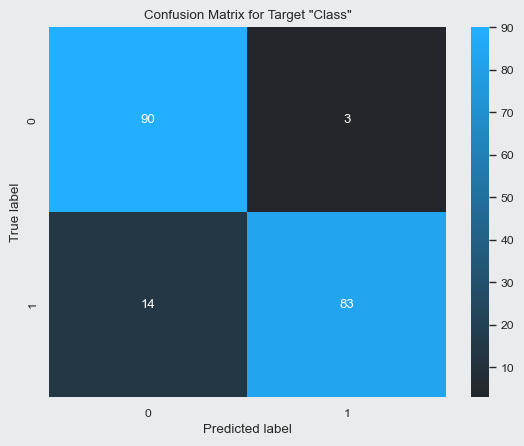

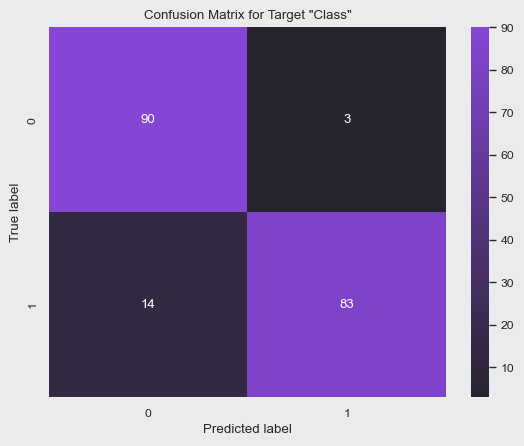

In [14]:
simple_confusion_matrix(y_true, rf_grid_search.predict(X_test_reduced_scaled), 'Class')

In [15]:
BEST_MODEL, BEST_SCORE = compare_models(rf_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.910463



-- Testing Results --
Accuracy    on Verification Data:	0.910526
Fbeta scroe on Verification Data:	0.866776

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        93
           1       0.95      0.87      0.91        97

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190

False negatives: 13 (13.978% out of 93 attacks, 6.842% overall)



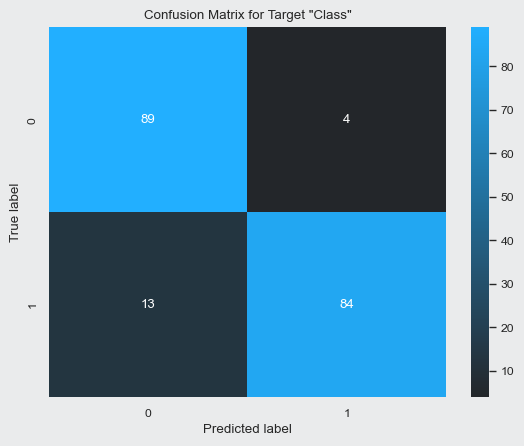

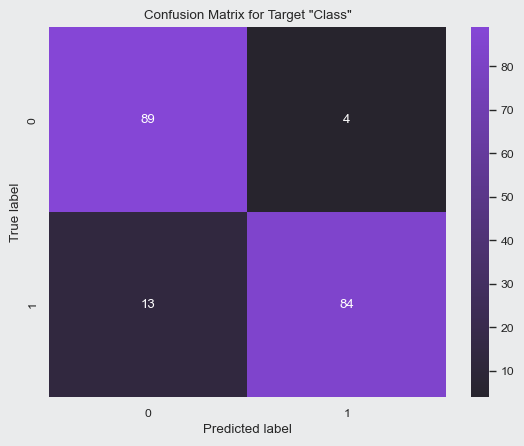

In [16]:
# Best model on the whole dataset
best_rf = rf_grid_search.best_estimator_.fit(X_train, y_train)
evaluate_model(best_rf, X_test, y_true, beta=beta, average='binary')
best_rf_pred = best_rf.predict(X_test)
simple_confusion_matrix(y_true, best_rf_pred, 'Class')


-- Testing Results --
Accuracy    on Verification Data:	0.976368
Fbeta scroe on Verification Data:	0.841051

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56650
           1       0.06      0.96      0.12        95

    accuracy                           0.98     56745
   macro avg       0.53      0.97      0.55     56745
weighted avg       1.00      0.98      0.99     56745

False negatives: 4 (4.211% out of 95 attacks, 0.007% overall)



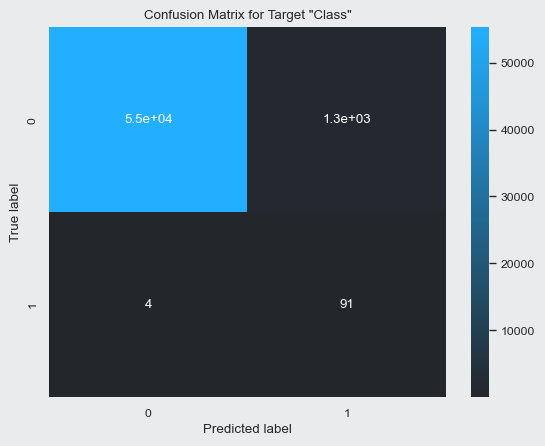

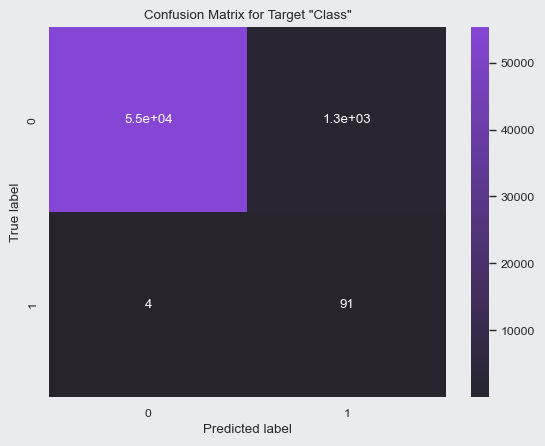

In [19]:
# Test on the Large Dataset
evaluate_model(best_rf, X_test_large, y_true_large, beta=beta, average='binary')
best_rf_pred = best_rf.predict(X_test_large)
simple_confusion_matrix(y_true_large, best_rf_pred, 'Class')

--------------------------------------------------------------------------------

# KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

## Hyperparameter Tuning

In [22]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [23]:
knn_param_grid = {
    'n_neighbors': [5, 10, 20, 50, 100, 150],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
}
knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.928 total time=   0.0s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.934 total time=   0.0s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.967 total time=   0.0s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.940 total time=   0.0s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.947 total time=   0.0s
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.928 total time=   0.0s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.934 total time=   0.0s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.960 total time=   0.0s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.947 total time=   0.0s
[CV 1/5] END n_jobs=-1, n_neighbors=10, weights=unifor

In [24]:
knn_result = evaluate_hpt(
    model=knn_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	5
	weights:	uniform
Best Score:
	0.943095

-- Testing Results --
Accuracy    on Verification Data:	0.900000
Fbeta scroe on Verification Data:	0.899882

              precision    recall  f1-score   support

           0       0.84      0.98      0.91        93
           1       0.98      0.82      0.89        97

    accuracy                           0.90       190
   macro avg       0.91      0.90      0.90       190
weighted avg       0.91      0.90      0.90       190

False negatives: 17 (18.280% out of 93 attacks, 8.947% overall)



In [25]:
_ = evaluate_hpt(
    model=knn_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	5
	weights:	uniform
Best Score:
	0.943095

-- Testing Results --
Accuracy    on Verification Data:	0.900000
Fbeta scroe on Verification Data:	0.826007

              precision    recall  f1-score   support

           0       0.84      0.98      0.91        93
           1       0.98      0.82      0.89        97

    accuracy                           0.90       190
   macro avg       0.91      0.90      0.90       190
weighted avg       0.91      0.90      0.90       190



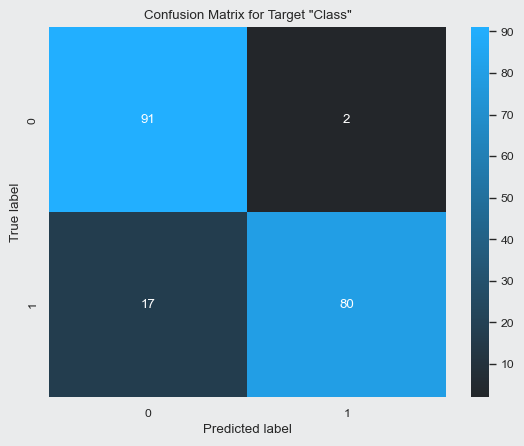

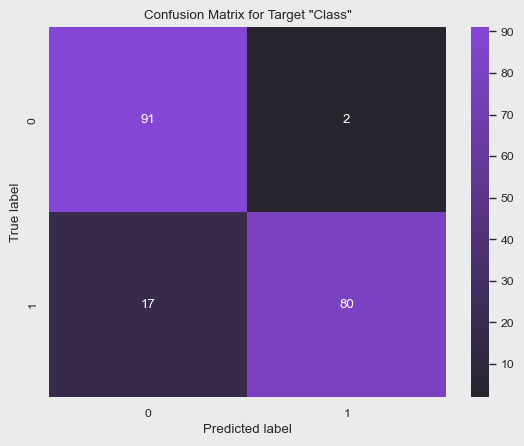

In [26]:
simple_confusion_matrix(y_true, knn_grid_search.predict(X_test_reduced_scaled), 'Class')

In [27]:
BEST_MODEL, BEST_SCORE = compare_models(knn_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.010581 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.010526 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.910463



-- Testing Results --
Accuracy    on Verification Data:	0.852632
Fbeta scroe on Verification Data:	0.784626

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        93
           1       0.92      0.78      0.84        97

    accuracy                           0.85       190
   macro avg       0.86      0.85      0.85       190
weighted avg       0.86      0.85      0.85       190

False negatives: 21 (22.581% out of 93 attacks, 11.053% overall)



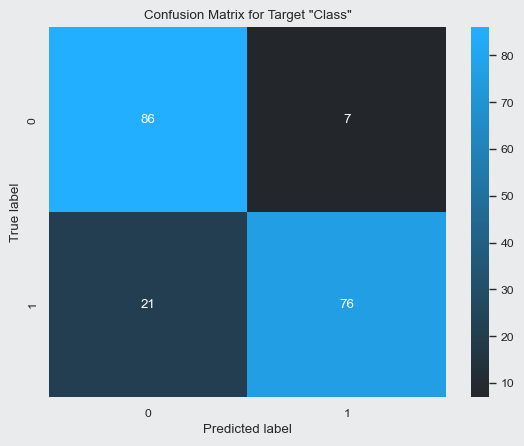

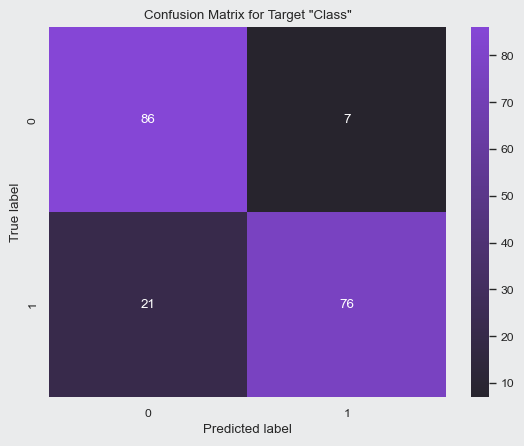

In [28]:
# Best model on the whole dataset
best_knn = knn_grid_search.best_estimator_.fit(X_train, y_train)
evaluate_model(best_knn, X_test, y_true, beta=beta, average='binary')
best_knn_pred = best_knn.predict(X_test)
simple_confusion_matrix(y_true, best_knn_pred, 'Class')


-- Testing Results --
Accuracy    on Verification Data:	0.938180
Fbeta scroe on Verification Data:	0.595163

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56650
           1       0.02      0.81      0.04        95

    accuracy                           0.94     56745
   macro avg       0.51      0.87      0.51     56745
weighted avg       1.00      0.94      0.97     56745

False negatives: 18 (18.947% out of 95 attacks, 0.032% overall)



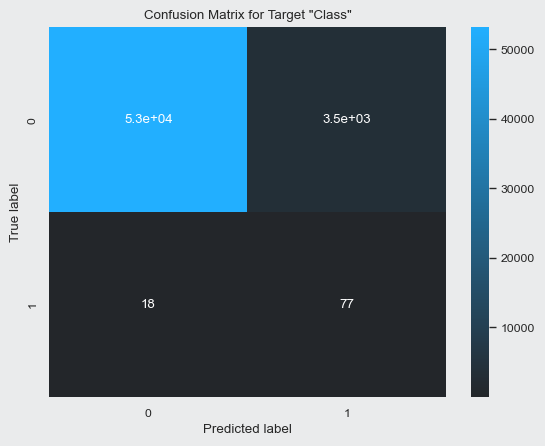

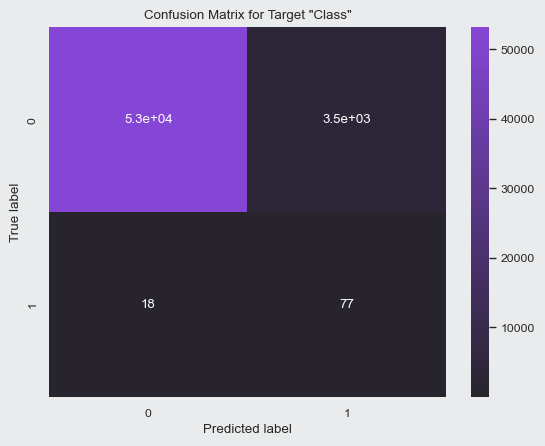

In [29]:
# Test on the Large Dataset
evaluate_model(best_knn, X_test_large, y_true_large, beta=beta, average='binary')
best_knn_pred = best_knn.predict(X_test_large)
simple_confusion_matrix(y_true_large, best_knn_pred, 'Class')

--------------------------------------------------------------------------------

# Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

## Hyperparameter Tuning

In [31]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [32]:
rel_positive = len(y[y==1]) / len(y)
gnb_param_grid = {
    'priors': [None, [1 - rel_positive, rel_positive]]
}
gnb_grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .......................priors=None;, score=0.901 total time=   0.0s
[CV 2/5] END .......................priors=None;, score=0.927 total time=   0.0s
[CV 3/5] END .......................priors=None;, score=0.934 total time=   0.0s
[CV 4/5] END .......................priors=None;, score=0.927 total time=   0.0s
[CV 5/5] END .......................priors=None;, score=0.927 total time=   0.0s
[CV 1/5] END .................priors=[0.5, 0.5];, score=0.901 total time=   0.0s
[CV 2/5] END .................priors=[0.5, 0.5];, score=0.927 total time=   0.0s
[CV 3/5] END .................priors=[0.5, 0.5];, score=0.934 total time=   0.0s
[CV 4/5] END .................priors=[0.5, 0.5];, score=0.927 total time=   0.0s
[CV 5/5] END .................priors=[0.5, 0.5];, score=0.927 total time=   0.0s


In [33]:
gnb_result = evaluate_hpt(
    model=gnb_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.923250

-- Testing Results --
Accuracy    on Verification Data:	0.868421
Fbeta scroe on Verification Data:	0.868270

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        93
           1       0.95      0.78      0.86        97

    accuracy                           0.87       190
   macro avg       0.88      0.87      0.87       190
weighted avg       0.88      0.87      0.87       190

False negatives: 21 (22.581% out of 93 attacks, 11.053% overall)



In [34]:
_ = evaluate_hpt(
    model=gnb_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.923250

-- Testing Results --
Accuracy    on Verification Data:	0.868421
Fbeta scroe on Verification Data:	0.784867

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        93
           1       0.95      0.78      0.86        97

    accuracy                           0.87       190
   macro avg       0.88      0.87      0.87       190
weighted avg       0.88      0.87      0.87       190



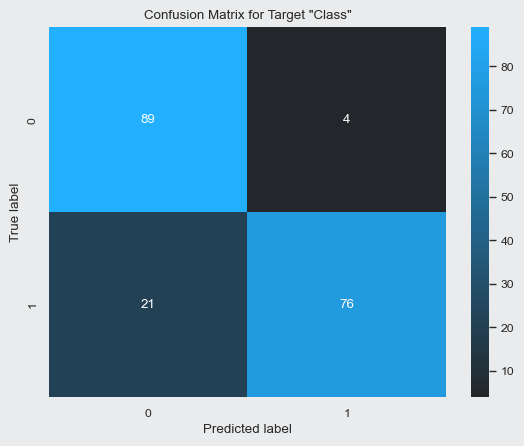

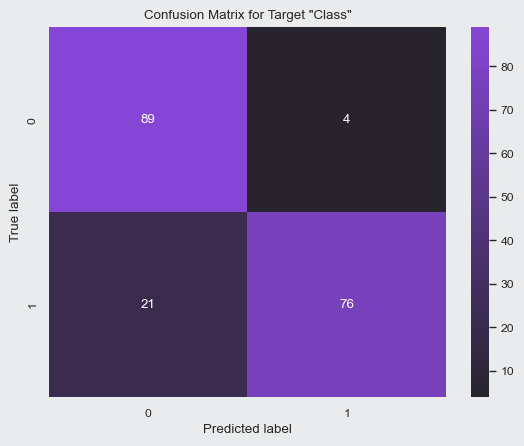

In [35]:
simple_confusion_matrix(y_true, gnb_grid_search.predict(X_test_reduced_scaled), 'Class')

In [36]:
BEST_MODEL, BEST_SCORE = compare_models(gnb_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.042193 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.042105 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.910463



-- Testing Results --
Accuracy    on Verification Data:	0.863158
Fbeta scroe on Verification Data:	0.794950

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        93
           1       0.93      0.79      0.86        97

    accuracy                           0.86       190
   macro avg       0.87      0.86      0.86       190
weighted avg       0.87      0.86      0.86       190

False negatives: 20 (21.505% out of 93 attacks, 10.526% overall)



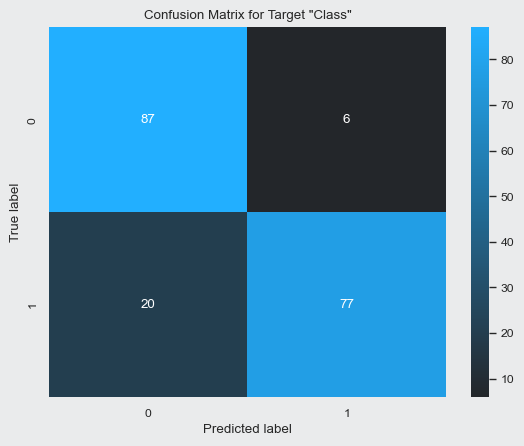

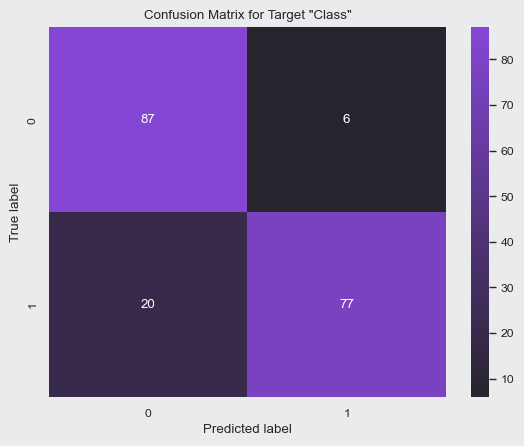

In [37]:
# Best model on the whole dataset
best_gnb = gnb_grid_search.best_estimator_.fit(X_train, y_train)
evaluate_model(best_gnb, X_test, y_true, beta=beta, average='binary')
best_gnb_pred = best_gnb.predict(X_test)
simple_confusion_matrix(y_true, best_gnb_pred, 'Class')


-- Testing Results --
Accuracy    on Verification Data:	0.963556
Fbeta scroe on Verification Data:	0.677444

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56650
           1       0.04      0.82      0.07        95

    accuracy                           0.96     56745
   macro avg       0.52      0.89      0.53     56745
weighted avg       1.00      0.96      0.98     56745

False negatives: 17 (17.895% out of 95 attacks, 0.030% overall)



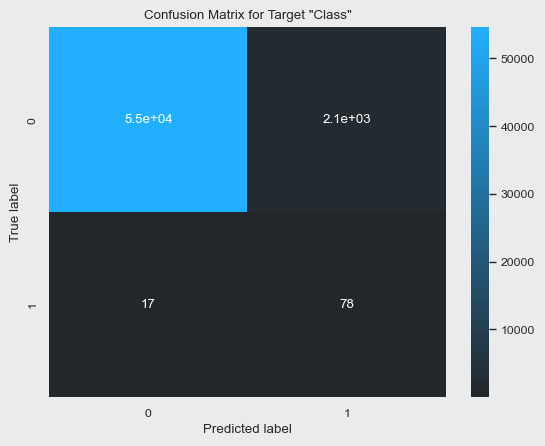

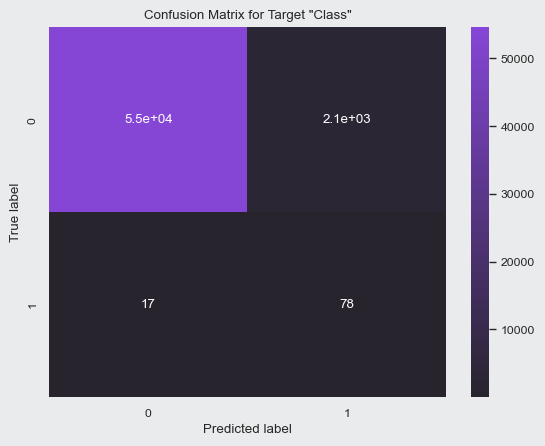

In [38]:
# Test on the Large Dataset
evaluate_model(best_gnb, X_test_large, y_true_large, beta=beta, average='binary')
best_gnb_pred = best_gnb.predict(X_test_large)
simple_confusion_matrix(y_true_large, best_gnb_pred, 'Class')

--------------------------------------------------------------------------------

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

## Hyperparameter Tuning

In [40]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
lr_param_grid = {
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5, 1.e-6],
    'C': [0.4 + 0.2*n for n in range(6)],
    'fit_intercept': [True, False],
    'max_iter': [7500],
    'n_jobs': [-1],
    'random_state': [404],
}
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=lr_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.914 total time=   2.1s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.960 total time=   0.3s
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.960 total time=   0.3s
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.920 total time=   0.0s
[CV 5/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.934 total time=   0.0s
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.914 total time=   0.0s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol

In [43]:
lr_result = evaluate_hpt(
    model=lr_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	max_iter:	7500
	n_jobs:	-1
	penalty:	None
	random_state:	404
	tol:	0.0001
Best Score:
	0.941780

-- Testing Results --
Accuracy    on Verification Data:	0.910526
Fbeta scroe on Verification Data:	0.910463

              precision    recall  f1-score   support

           0       0.87      0.97      0.91        93
           1       0.97      0.86      0.91        97

    accuracy                           0.91       190
   macro avg       0.92      0.91      0.91       190
weighted avg       0.92      0.91      0.91       190

False negatives: 14 (15.054% out of 93 attacks, 7.368% overall)



In [44]:
_ = evaluate_hpt(
    model=lr_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	max_iter:	7500
	n_jobs:	-1
	penalty:	None
	random_state:	404
	tol:	0.0001
Best Score:
	0.941780

-- Testing Results --
Accuracy    on Verification Data:	0.910526
Fbeta scroe on Verification Data:	0.856632

              precision    recall  f1-score   support

           0       0.87      0.97      0.91        93
           1       0.97      0.86      0.91        97

    accuracy                           0.91       190
   macro avg       0.92      0.91      0.91       190
weighted avg       0.92      0.91      0.91       190



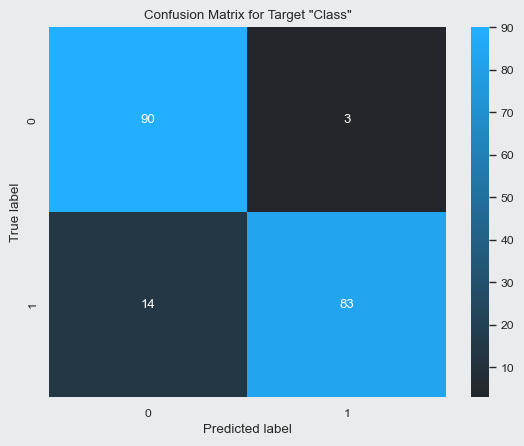

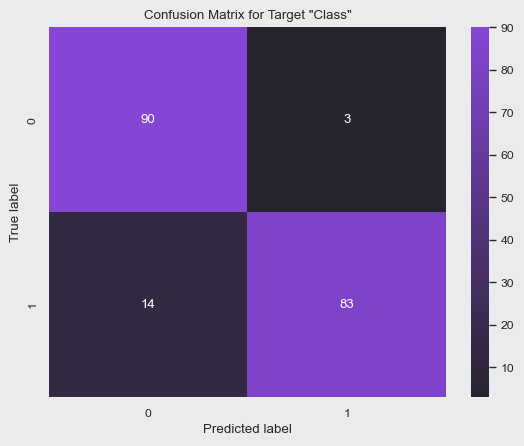

In [45]:
simple_confusion_matrix(y_true, lr_grid_search.predict(X_test_reduced_scaled), 'Class')

In [46]:
BEST_MODEL, BEST_SCORE = compare_models(lr_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.910463



-- Testing Results --
Accuracy    on Verification Data:	0.921053
Fbeta scroe on Verification Data:	0.887232

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        93
           1       0.96      0.89      0.92        97

    accuracy                           0.92       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.92      0.92      0.92       190

False negatives: 11 (11.828% out of 93 attacks, 5.789% overall)



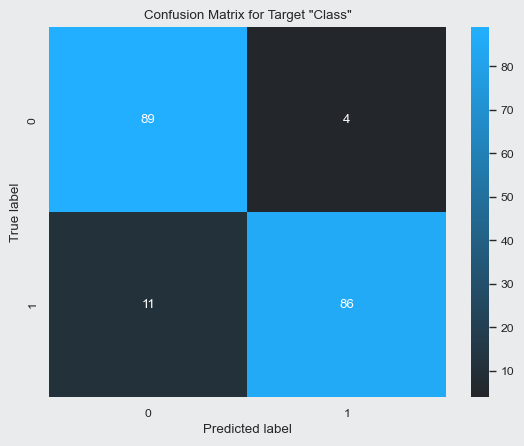

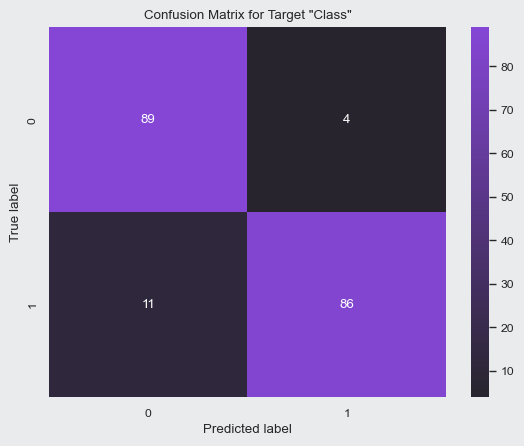

In [47]:
# Best model on the whole dataset
best_lr = lr_grid_search.best_estimator_.fit(X_train, y_train)
evaluate_model(best_lr, X_test, y_true, beta=beta, average='binary')
best_lr_pred = best_lr.predict(X_test)
simple_confusion_matrix(y_true, best_lr_pred, 'Class')


-- Testing Results --
Accuracy    on Verification Data:	0.960948
Fbeta scroe on Verification Data:	0.744977

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56650
           1       0.04      0.92      0.07        95

    accuracy                           0.96     56745
   macro avg       0.52      0.94      0.53     56745
weighted avg       1.00      0.96      0.98     56745

False negatives: 8 (8.421% out of 95 attacks, 0.014% overall)



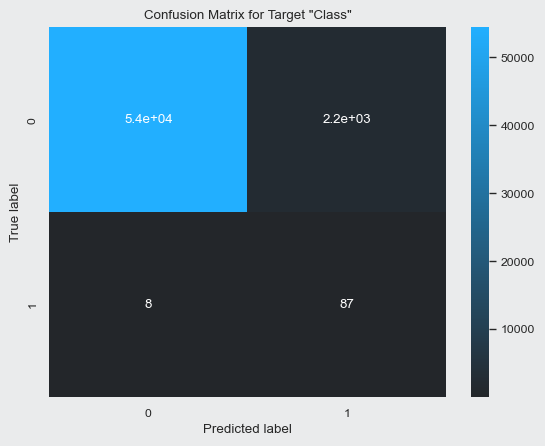

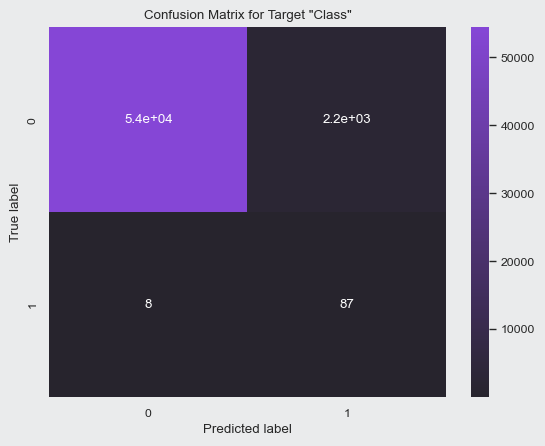

In [48]:
# Test on the Large Dataset
evaluate_model(best_lr, X_test_large, y_true_large, beta=beta, average='binary')
best_lr_pred = best_lr.predict(X_test_large)
simple_confusion_matrix(y_true_large, best_lr_pred, 'Class')

--------------------------------------------------------------------------------

# Support Vector Machine

In [54]:
from sklearn.svm import SVC

## Hyperparameter Tuning

In [55]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [56]:
svc_param_grid = {
    'C': [0.4 + 0.2*n for n in range(6)],
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, len(selected_columns)],
    'gamma': ['scale', 'auto'],
    'tol': [1.e-3, 1.e-5, 1.e-6],
    'max_iter': [10_000],
    'random_state': [404]
}
svc_grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=svc_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.914 total time=   0.0s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.960 total time=   0.0s
[CV 3/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.960 total time=   0.0s
[CV 4/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.920 total time=   0.0s
[CV 5/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.940 total time=   0.0s
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=0.914 total time=   0.0s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=0.960 total time

In [57]:
svc_result = evaluate_hpt(
    model=svc_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	C:	1.0
	degree:	3
	gamma:	scale
	kernel:	linear
	max_iter:	10000
	random_state:	404
	tol:	0.001
Best Score:
	0.941801

-- Testing Results --
Accuracy    on Verification Data:	0.905263
Fbeta scroe on Verification Data:	0.905188

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        93
           1       0.96      0.85      0.90        97

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190

False negatives: 15 (16.129% out of 93 attacks, 7.895% overall)



In [58]:
_ = evaluate_hpt(
    model=svc_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	C:	1.0
	degree:	3
	gamma:	scale
	kernel:	linear
	max_iter:	10000
	random_state:	404
	tol:	0.001
Best Score:
	0.941801

-- Testing Results --
Accuracy    on Verification Data:	0.905263
Fbeta scroe on Verification Data:	0.846398

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        93
           1       0.96      0.85      0.90        97

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190



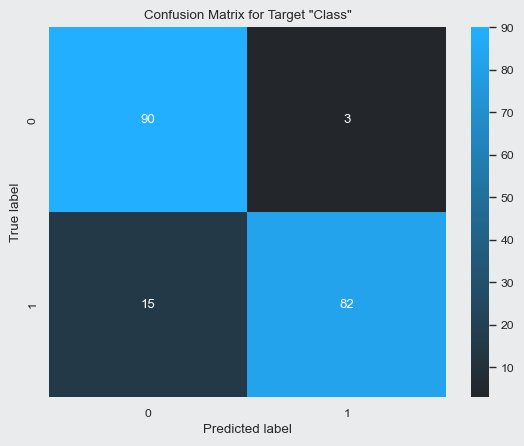

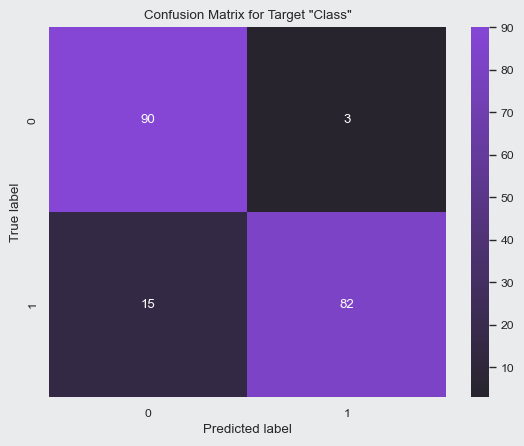

In [59]:
simple_confusion_matrix(y_true, svc_grid_search.predict(X_test_reduced_scaled), 'Class')

In [60]:
BEST_MODEL, BEST_SCORE = compare_models(svc_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.005275 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.005263 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.910463



-- Testing Results --
Accuracy    on Verification Data:	0.863158
Fbeta scroe on Verification Data:	0.815265

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        93
           1       0.91      0.81      0.86        97

    accuracy                           0.86       190
   macro avg       0.87      0.86      0.86       190
weighted avg       0.87      0.86      0.86       190

False negatives: 18 (19.355% out of 93 attacks, 9.474% overall)



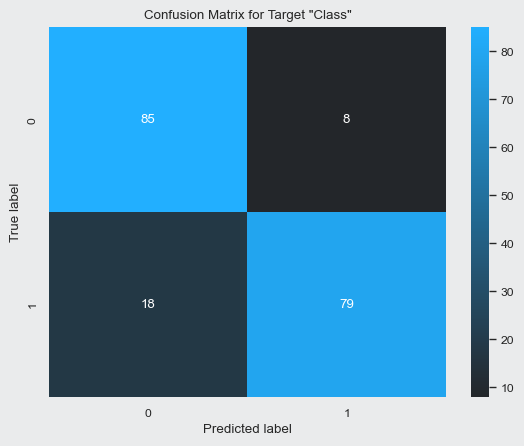

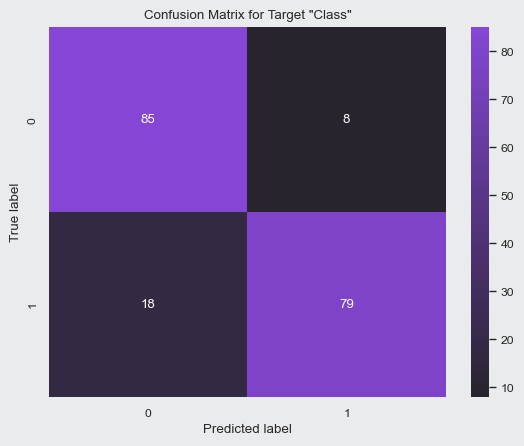

In [61]:
# Best model on the whole dataset
best_svc = svc_grid_search.best_estimator_.fit(X_train, y_train)
evaluate_model(best_svc, X_test, y_true, beta=beta, average='binary')
best_svc_pred = best_svc.predict(X_test)
simple_confusion_matrix(y_true, best_svc_pred, 'Class')


-- Testing Results --
Accuracy    on Verification Data:	0.929439
Fbeta scroe on Verification Data:	0.573398

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56650
           1       0.02      0.81      0.04        95

    accuracy                           0.93     56745
   macro avg       0.51      0.87      0.50     56745
weighted avg       1.00      0.93      0.96     56745

False negatives: 18 (18.947% out of 95 attacks, 0.032% overall)



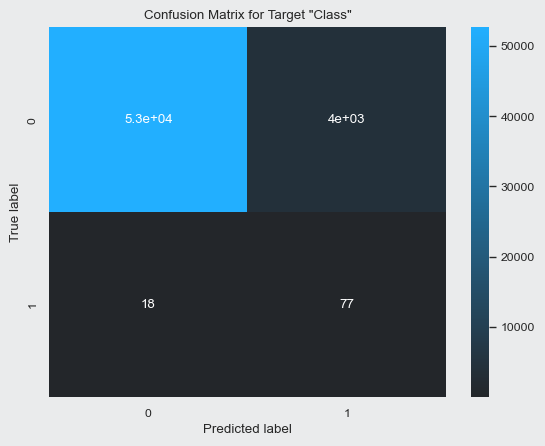

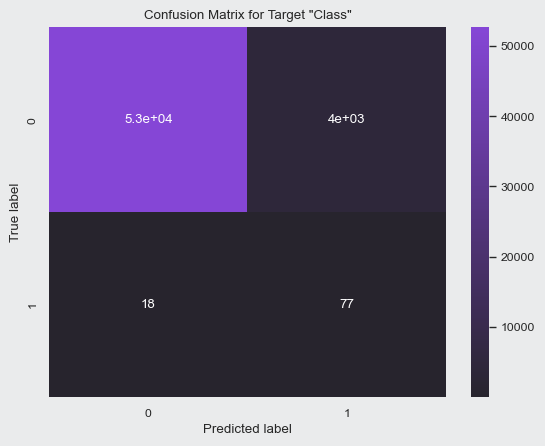

In [62]:
# Test on the Large Dataset
evaluate_model(best_svc, X_test_large, y_true_large, beta=beta, average='binary')
best_svc_pred = best_svc.predict(X_test_large)
simple_confusion_matrix(y_true_large, best_svc_pred, 'Class')